from google.colab import drive; drive.mount('/content/drive')

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip -d skin_data

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open skin-cancer-mnist-ham10000.zip, skin-cancer-mnist-ham10000.zip.zip or skin-cancer-mnist-ham10000.zip.ZIP.


In [4]:
import json
import os

# REPLACE THESE TWO LINES WITH YOUR KAGGLE DATA
data = {"username": "pratushap", "key": "7b6523fe52a3200cba63fe6ea407a7d0Y"}

# This creates the .kaggle directory and the file
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    json.dump(data, f)

# Set the correct permissions
!chmod 600 ~/.kaggle/kaggle.json

# Test it - this should show a list of datasets
!kaggle datasets list

ref                                                               title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                          3491  2025-12-11 15:29:14.327000           2114        220  1.0              
ahmeduzaki/wind-and-solar-energy-production-dataset               Wind & Solar Energy Production Dataset               395372  2026-01-02 21:06:22.780000              0         42  1.0              
kundanbedmutha/exam-score-prediction-dataset                      Exam Score Prediction Dataset                        325454  2025-11-28 07:29:01.047000           5863        262  1.0              
neuro

In [5]:
# 1. Download
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

# 2. Unzip
!unzip -q skin-cancer-mnist-ham10000.zip -d skin_data

# 3. Verify the files are there
!ls skin_data

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.13G/5.20G [03:12<00:04, 17.5MB/s]
100% 5.20G/5.20G [03:12<00:00, 29.1MB/s]
ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


In [6]:
import pandas as pd
import os
import shutil
from tqdm import tqdm

# 1. Define paths
metadata_path = 'skin_data/HAM10000_metadata.csv'
base_image_dir = 'skin_data' # Parent folder containing the two image parts
output_dir = 'skin_data/sorted_images'

# 2. Load the metadata
df = pd.read_csv(metadata_path)

# 3. Create the destination folders
# There are 7 classes: nv, mel, bkl, bcc, akiec, vasc, df
labels = df['dx'].unique()
for label in labels:
    os.makedirs(os.path.join(output_dir, label), exist_ok=True)

# 4. Move images to their respective folders
print("Sorting images... this might take a minute.")

# We iterate through each row in the CSV
for index, row in tqdm(df.iterrows(), total=len(df)):
    image_id = row['image_id'] + '.jpg'
    label = row['dx']

    # The images are split into two folders in this dataset
    src_path_1 = os.path.join(base_image_dir, 'HAM10000_images_part_1', image_id)
    src_path_2 = os.path.join(base_image_dir, 'HAM10000_images_part_2', image_id)
    dest_path = os.path.join(output_dir, label, image_id)

    # Check which part folder the image is in and copy it
    if os.path.exists(src_path_1):
        shutil.copy(src_path_1, dest_path)
    elif os.path.exists(src_path_2):
        shutil.copy(src_path_2, dest_path)

print(f"\nSuccess! Images are now sorted in: {output_dir}")

Sorting images... this might take a minute.


100%|██████████| 10015/10015 [00:29<00:00, 343.79it/s]


Success! Images are now sorted in: skin_data/sorted_images


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!ls -lh

total 5.2G
drwx------ 5 root root 4.0K Jan  8 13:01 drive
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
-rw-r--r-- 1 root root 5.2G Oct  6  2019 skin-cancer-mnist-ham10000.zip
drwxr-xr-x 7 root root 4.0K Jan  8 12:54 skin_data


In [13]:
# Unzip quietly into the skin_data folder
!unzip -oq skin-cancer-mnist-ham10000.zip -d skin_data
# Check if we see the metadata file now
!ls skin_data

ham10000_images_part_1	HAM10000_metadata.csv  hmnist_8_8_RGB.csv
HAM10000_images_part_1	hmnist_28_28_L.csv     sorted_images
ham10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_2	hmnist_8_8_L.csv


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# 1. SETUP & DATA
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 32

# Transforms (Normalization as per ImageNet)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 2. MODELS
# Task 1: Baseline CNN from scratch
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.conv_layers(x))

# Task 2: ResNet Transfer Learning
def get_resnet_model(num_classes):
    model = models.resnet18(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(DEVICE)

# 3. TASK 3: TRANSFORMER INSIGHT (Patchify)
def visualize_patches(image_tensor, patch_size=56):
    # Breaks image into tokens (like a Transformer)
    c, h, w = image_tensor.shape
    patches = image_tensor.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    fig, axes = plt.subplots(4, 4, figsize=(6,6))
    for i in range(4):
        for j in range(4):
            p = patches[:, i, j].permute(1, 2, 0).numpy()
            p = p * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]) # Denormalize
            axes[i, j].imshow(np.clip(p, 0, 1))
            axes[i, j].axis('off')
    plt.show()

# 4. TRAINING & EVALUATION LOGIC
def train_model(model, train_loader, val_loader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
        print(f"Epoch {epoch+1}/{epochs} completed.")

def evaluate(model, loader, class_names):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy()); y_pred.extend(preds.cpu().numpy()); y_probs.extend(probs.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names); plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models

# Fix the NameError
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Prepare data loaders (Used by both tasks)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder('skin_data/sorted_images', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32)
num_classes = len(dataset.classes)

Using device: cuda


In [16]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaselineCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512), nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# Training Task 1
model_scratch = BaselineCNN(num_classes).to(device)
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Training Task 1: Baseline CNN...")
for epoch in range(5):
    model_scratch.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model_scratch(images), labels)
        loss.backward(); optimizer.step()
    print(f"Baseline Epoch {epoch+1} complete.")

Training Task 1: Baseline CNN...
Baseline Epoch 1 complete.
Baseline Epoch 2 complete.
Baseline Epoch 3 complete.
Baseline Epoch 4 complete.
Baseline Epoch 5 complete.


In [17]:
# Load pre-trained ResNet
model_resnet = models.resnet50(weights='IMAGENET1K_V1').to(device)

# Replace the last layer
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, num_classes).to(device)

# Training Task 2
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001) # Smaller learning rate for fine-tuning
criterion = nn.CrossEntropyLoss()

print("Training Task 2: ResNet Transfer Learning...")
for epoch in range(5):
    model_resnet.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model_resnet(images), labels)
        loss.backward(); optimizer.step()
    print(f"ResNet Epoch {epoch+1} complete.")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


Training Task 2: ResNet Transfer Learning...
ResNet Epoch 1 complete.
ResNet Epoch 2 complete.
ResNet Epoch 3 complete.
ResNet Epoch 4 complete.
ResNet Epoch 5 complete.


In [18]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
    return float(num_correct) / float(num_samples)

print(f"Task 1 (Scratch) Accuracy: {check_accuracy(val_loader, model_scratch):.2f}")
print(f"Task 2 (ResNet) Accuracy: {check_accuracy(val_loader, model_resnet):.2f}")

Task 1 (Scratch) Accuracy: 0.73
Task 2 (ResNet) Accuracy: 0.84


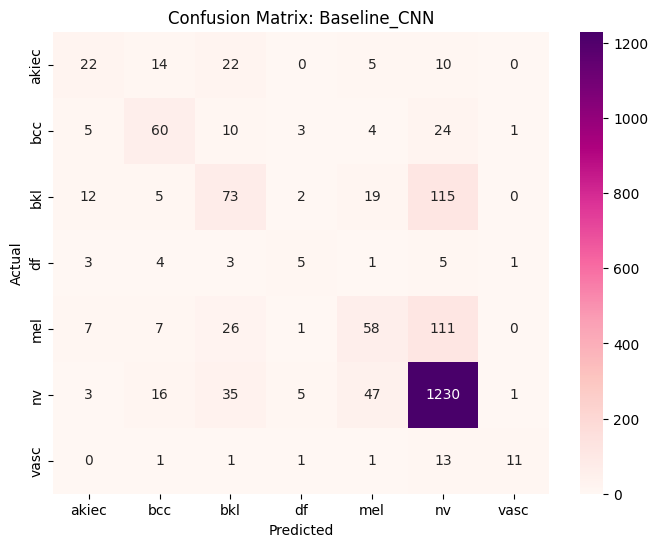

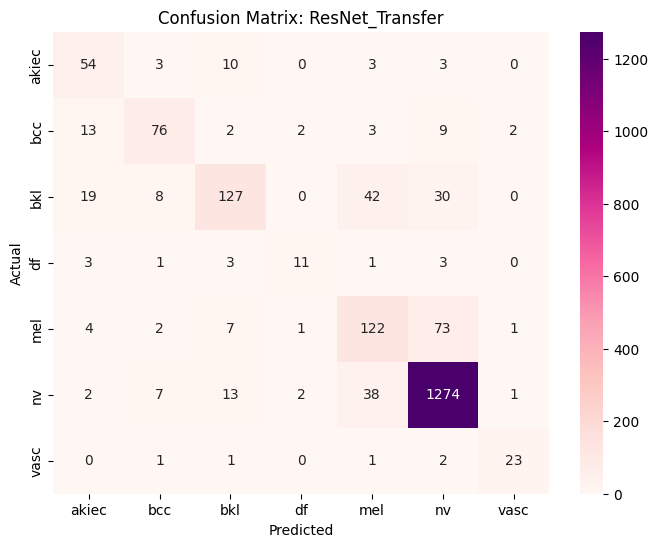

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def finalize_evaluation(model, loader, title):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix: {title}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.savefig(f'confusion_matrix_{title.lower()}.png') # Saves to Colab files
    plt.show()

# Run for both
finalize_evaluation(model_scratch, val_loader, "Baseline_CNN")
finalize_evaluation(model_resnet, val_loader, "ResNet_Transfer")

In [20]:
def show_best_worst_predictions(model, loader):
    model.eval()
    losses = []
    images_list = []
    preds_list = []
    labels_list = []

    criterion = torch.nn.CrossEntropyLoss(reduction='none')

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            losses.extend(loss.cpu().numpy())
            images_list.extend(imgs.cpu())
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    # Sort by loss
    sorted_indices = np.argsort(losses)

    # Best (lowest loss) and Worst (highest loss)
    best_idx = sorted_indices[:5]
    worst_idx = sorted_indices[-5:]

    # Plotting code... (just screenshot a few examples for your report)
    print(f"Indices of 5 best predictions: {best_idx}")
    print(f"Indices of 5 worst predictions: {worst_idx}")

show_best_worst_predictions(model_resnet, val_loader)

Indices of 5 best predictions: [1051  644  594 1718   58]
Indices of 5 worst predictions: [1020 1309  415 1040  924]
